# Analisis Jaringan Jalan dan Aksesibilitas Fasilitas Kesehatan Menggunakan Data Geospasial OpenStreetMap dan OSMNX: Studi Kasus Kota Sukabumi

**Nama: Maryesta Apriliani Sihombing**

**NPM: 2206051531**

Proyek mini untuk analisis spasial jaringan jalan dan aksesibilitas kesehatan di Kota Sukabumi.

## Rumusan Maasalah
1.	Bagaimana struktur jaringan jalan di Kota Sukabumi dan analisisnya menggunakan data geospasial tidak terstruktur dari OpenStreetMap?
2.	Bagaimana peran simpul-simpul tertentu dalam jaringan jalan Kota Sukabumi jika diukur menggunakan metrik centrality seperti degree, betweenness, closeness, dan eigenvector?
3.	Bagaimana tingkat aksesibilitas masyarakat terhadap fasilitas kesehatan di Kota Sukabumi berdasarkan jarak spasial dari jaringan jalan?
4.	Wilayah mana saja yang belum terjangkau fasilitas kesehatan secara memadai (healthcare deserts) dan bagaimana keterkaitannya dengan simpul-simpul strategis dalam jaringan transportasi kota?
5.	Bagaimana integrasi analisis jaringan dan akses kesehatan dapat dimanfaatkan untuk merekomendasikan lokasi prioritas pembangunan fasilitas kesehatan?



## Tujuan:
1.	Memahami dan menganalisis struktur jaringan jalan Kota Sukabumi dari data geospasial tidak terstruktur dari OpenStreetMap.
2.	Mengidentifikasi peran simpul-simpul tertentu dalam jaringan jalan Kota Sukabumi jika diukur menggunakan metrik centrality seperti degree, betweenness, closeness, dan eigenvector melalui analisis multi-centrality.
3.	Mengidentifikasi tingkat aksesibilitas masyarakat terhadap fasilitas kesehatan di Kota Sukabumi berdasarkan jarak spasial dari jaringan jalan?
4.	Mengidentifikasi wilayah yang belum terjangkau fasilitas kesehatan secara memadai (healthcare deserts), serta menganalisis apakah wilayah tersebut berada di simpul strategis.
5.	Menyusun rekomendasi lokasi pembangunan fasilitas kesehatan berdasarkan integrasi analisis jaringan dan akses kesehatan.



In [1]:
# 🔧 Install dependencies
!pip install osmnx --upgrade folium geopandas networkx --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.0/338.0 kB 6.2 MB/s eta 0:00:00


In [2]:
# 📚 Import libraries
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import folium
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
from folium import plugins
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 🌍 Ambil jaringan jalan Kota Sukabumi
place = "Sukabumi, West Java, Indonesia"
G = ox.graph_from_place(place, network_type="drive")
nodes, edges = ox.graph_to_gdfs(G)
print(f"✅ Berhasil mengambil {len(nodes)} nodes dan {len(edges)} edges")

In [4]:
# 📊 Statistik jaringan
stats = ox.basic_stats(G)
pd.Series(stats).head(10)

n                                                                            4439
m                                                                           10329
k_avg                                                                    4.653751
edge_length_total                                                   786517.217029
edge_length_avg                                                         76.146502
streets_per_node_avg                                                     2.395359
streets_per_node_counts              {0: 0, 1: 1472, 2: 1, 3: 2706, 4: 259, 5: 1}
streets_per_node_proportions    {0: 0.0, 1: 0.3316062176165803, 2: 0.000225275...
intersection_count                                                           2967
street_length_total                                                 405529.739087
dtype: object

# MULTI-CENTRALITY ANALYSIS

In [6]:
# 1. Degree Centrality - Menunjukkan seberapa banyak koneksi langsung suatu node
print("📍 Menghitung Degree Centrality...")
degree_centrality = nx.degree_centrality(G)

# 2. Betweenness Centrality - Menunjukkan seberapa sering suatu node dilalui dalam jalur terpendek
print("🔗 Menghitung Betweenness Centrality...")
betweenness_centrality = nx.betweenness_centrality(G, weight='length', k=1000)  # k=1000 untuk sampling

# 3. Closeness Centrality - Menunjukkan seberapa dekat suatu node ke semua node lain
print("📏 Menghitung Closeness Centrality...")
closeness_centrality = nx.closeness_centrality(G, distance='length')

# 4. Eigenvector Centrality - Menunjukkan pentingnya node berdasarkan pentingnya tetangganya
print("🏆 Menghitung Eigenvector Centrality...")
try:
    eigenvector_centrality = nx.eigenvector_centrality(G, weight='length', max_iter=1000)
except:
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G, weight='length')

# Menambahkan hasil centrality ke graph
nx.set_node_attributes(G, degree_centrality, "degree_centrality")
nx.set_node_attributes(G, betweenness_centrality, "betweenness_centrality")
nx.set_node_attributes(G, closeness_centrality, "closeness_centrality")
nx.set_node_attributes(G, eigenvector_centrality, "eigenvector_centrality")

print("✅ Semua centrality metrics berhasil dihitung!")

📍 Menghitung Degree Centrality...
🔗 Menghitung Betweenness Centrality...
📏 Menghitung Closeness Centrality...
🏆 Menghitung Eigenvector Centrality...
✅ Semua centrality metrics berhasil dihitung!


In [7]:
# 📊 Membuat DataFrame untuk analisis
centrality_df = pd.DataFrame({
    'node_id': list(G.nodes()),
    'degree_centrality': [degree_centrality[node] for node in G.nodes()],
    'betweenness_centrality': [betweenness_centrality[node] for node in G.nodes()],
    'closeness_centrality': [closeness_centrality[node] for node in G.nodes()],
    'eigenvector_centrality': [eigenvector_centrality[node] for node in G.nodes()]
})

# Menambahkan koordinat node
node_coords = {node: (data['y'], data['x']) for node, data in G.nodes(data=True)}
centrality_df['lat'] = [node_coords[node][0] for node in centrality_df['node_id']]
centrality_df['lon'] = [node_coords[node][1] for node in centrality_df['node_id']]

print("\n📈 Statistik Deskriptif Centrality Metrics:")
print(centrality_df[['degree_centrality', 'betweenness_centrality',
                    'closeness_centrality', 'eigenvector_centrality']].describe())


📈 Statistik Deskriptif Centrality Metrics:
       degree_centrality  betweenness_centrality  closeness_centrality  \
count        4439.000000             4439.000000           4439.000000   
mean            0.001049                0.013017              0.000182   
std             0.000450                0.027342              0.000031   
min             0.000451                0.000000              0.000106   
25%             0.000451                0.000000              0.000157   
50%             0.001352                0.001233              0.000179   
75%             0.001352                0.011402              0.000207   
max             0.001803                0.226847              0.000246   

       eigenvector_centrality  
count            4.439000e+03  
mean             3.657817e-04  
std              1.500643e-02  
min             -5.874640e-16  
25%             -1.055257e-18  
50%              1.981817e-19  
75%              2.358226e-18  
max              7.069847e-01  


In [8]:
centrality_df[['degree_centrality', 'betweenness_centrality',
                    'closeness_centrality', 'eigenvector_centrality']].describe()

degree_centrality  betweenness_centrality  closeness_centrality  \
count        4439.000000             4439.000000           4439.000000   
mean            0.001049                0.013017              0.000182   
std             0.000450                0.027342              0.000031   
min             0.000451                0.000000              0.000106   
25%             0.000451                0.000000              0.000157   
50%             0.001352                0.001233              0.000179   
75%             0.001352                0.011402              0.000207   
max             0.001803                0.226847              0.000246   

       eigenvector_centrality  
count            4.439000e+03  
mean             3.657817e-04  
std              1.500643e-02  
min             -5.874640e-16  
25%             -1.055257e-18  
50%              1.981817e-19  
75%              2.358226e-18  
max              7.069847e-01

In [9]:
# 🏆 Top 10 nodes untuk setiap centrality metric
print("\n🏆 TOP 10 NODES PER CENTRALITY METRIC:")

top_metrics = {}
for metric in ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality']:
    top_10 = centrality_df.nlargest(10, metric)[['node_id', metric, 'lat', 'lon']]
    top_metrics[metric] = top_10
    print(f"\n🔥 Top 10 {metric.replace('_', ' ').title()}:")
    print(top_10)


🏆 TOP 10 NODES PER CENTRALITY METRIC:

🔥 Top 10 Degree Centrality:
        node_id  degree_centrality       lat         lon
46   2413854235           0.001803 -6.922156  106.922110
52   2413854256           0.001803 -6.922701  106.924380
54   2413854266           0.001803 -6.923016  106.921953
84   2501743074           0.001803 -6.903123  106.915672
85   2501743078           0.001803 -6.903167  106.912572
98   2501743353           0.001803 -6.912175  106.929137
122  2504526961           0.001803 -6.958860  106.953062
149  2828213861           0.001803 -6.918355  106.913617
180  2828228711           0.001803 -6.913179  106.930870
185  2828228743           0.001803 -6.915352  106.914387

🔥 Top 10 Betweenness Centrality:
         node_id  betweenness_centrality       lat         lon
2520  6428220416                0.226847 -6.926309  106.933505
3757  9334320572                0.224290 -6.927239  106.933389
0      664143921                0.219427 -6.950868  106.931317
3274  7371392360   

## Visualisasi Multi-Centrality

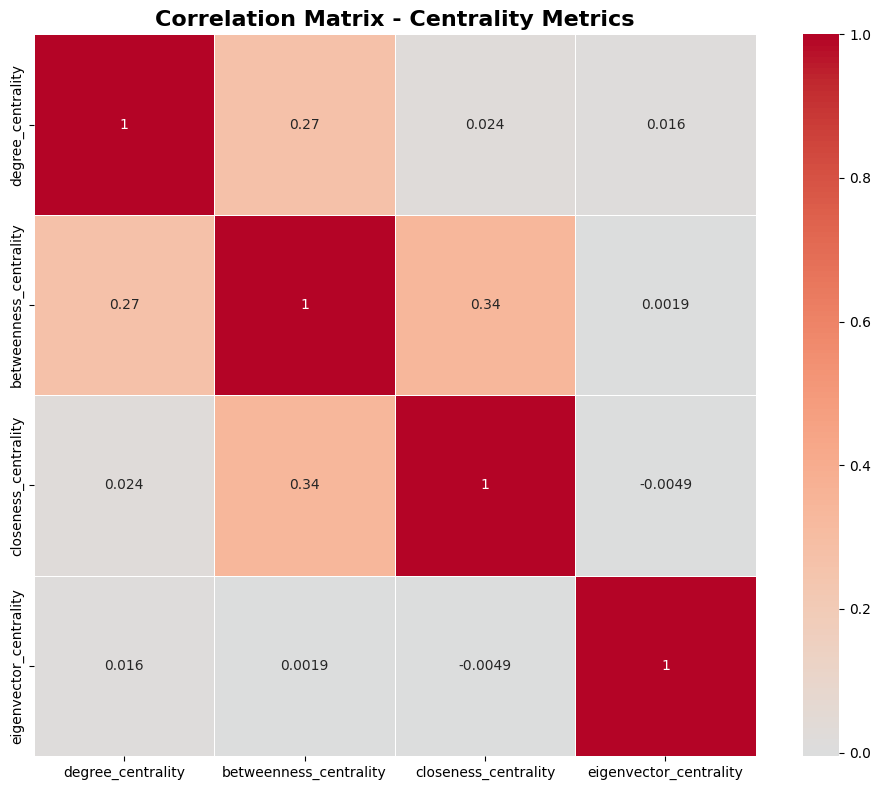

In [10]:
# 1. Correlation Matrix
fig, ax = plt.subplots(figsize=(10, 8))
correlation_matrix = centrality_df[['degree_centrality', 'betweenness_centrality',
                                   'closeness_centrality', 'eigenvector_centrality']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, ax=ax)
plt.title('Correlation Matrix - Centrality Metrics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

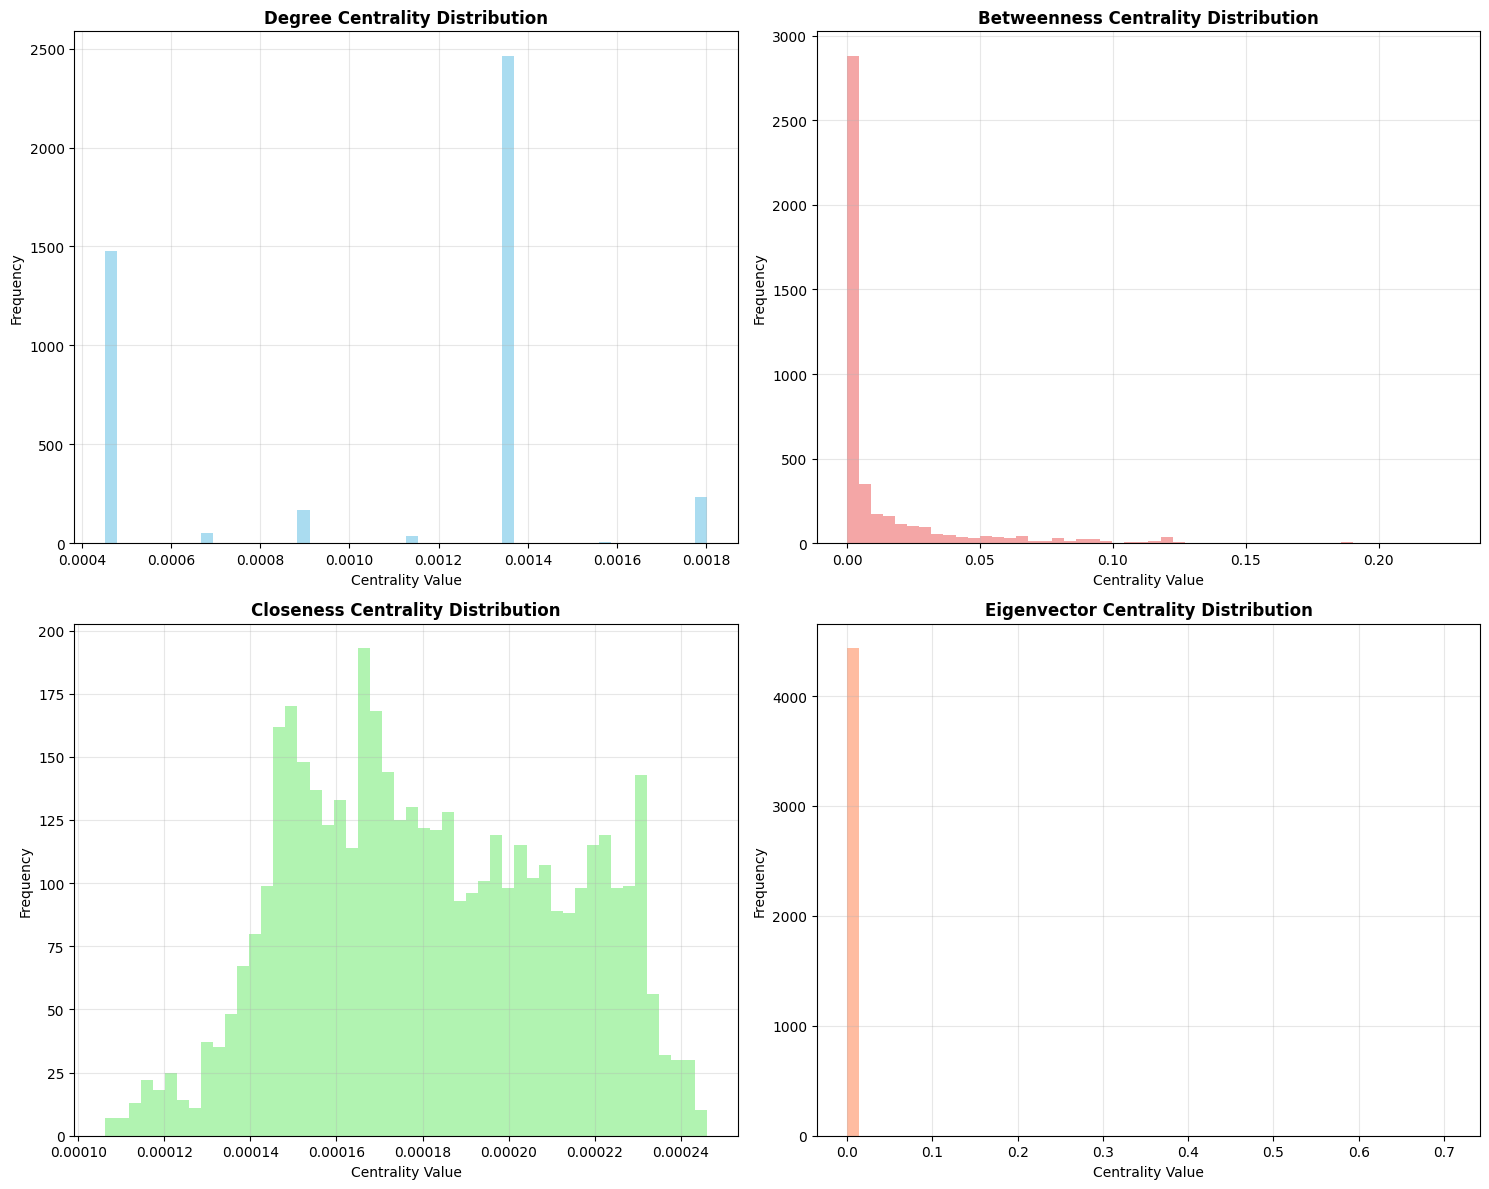

In [11]:
# 2. Distribution plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[i//2, i%2]
    centrality_df[metric].hist(bins=50, alpha=0.7, color=color, ax=ax)
    ax.set_title(f'{metric.replace("_", " ").title()} Distribution', fontweight='bold')
    ax.set_xlabel('Centrality Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

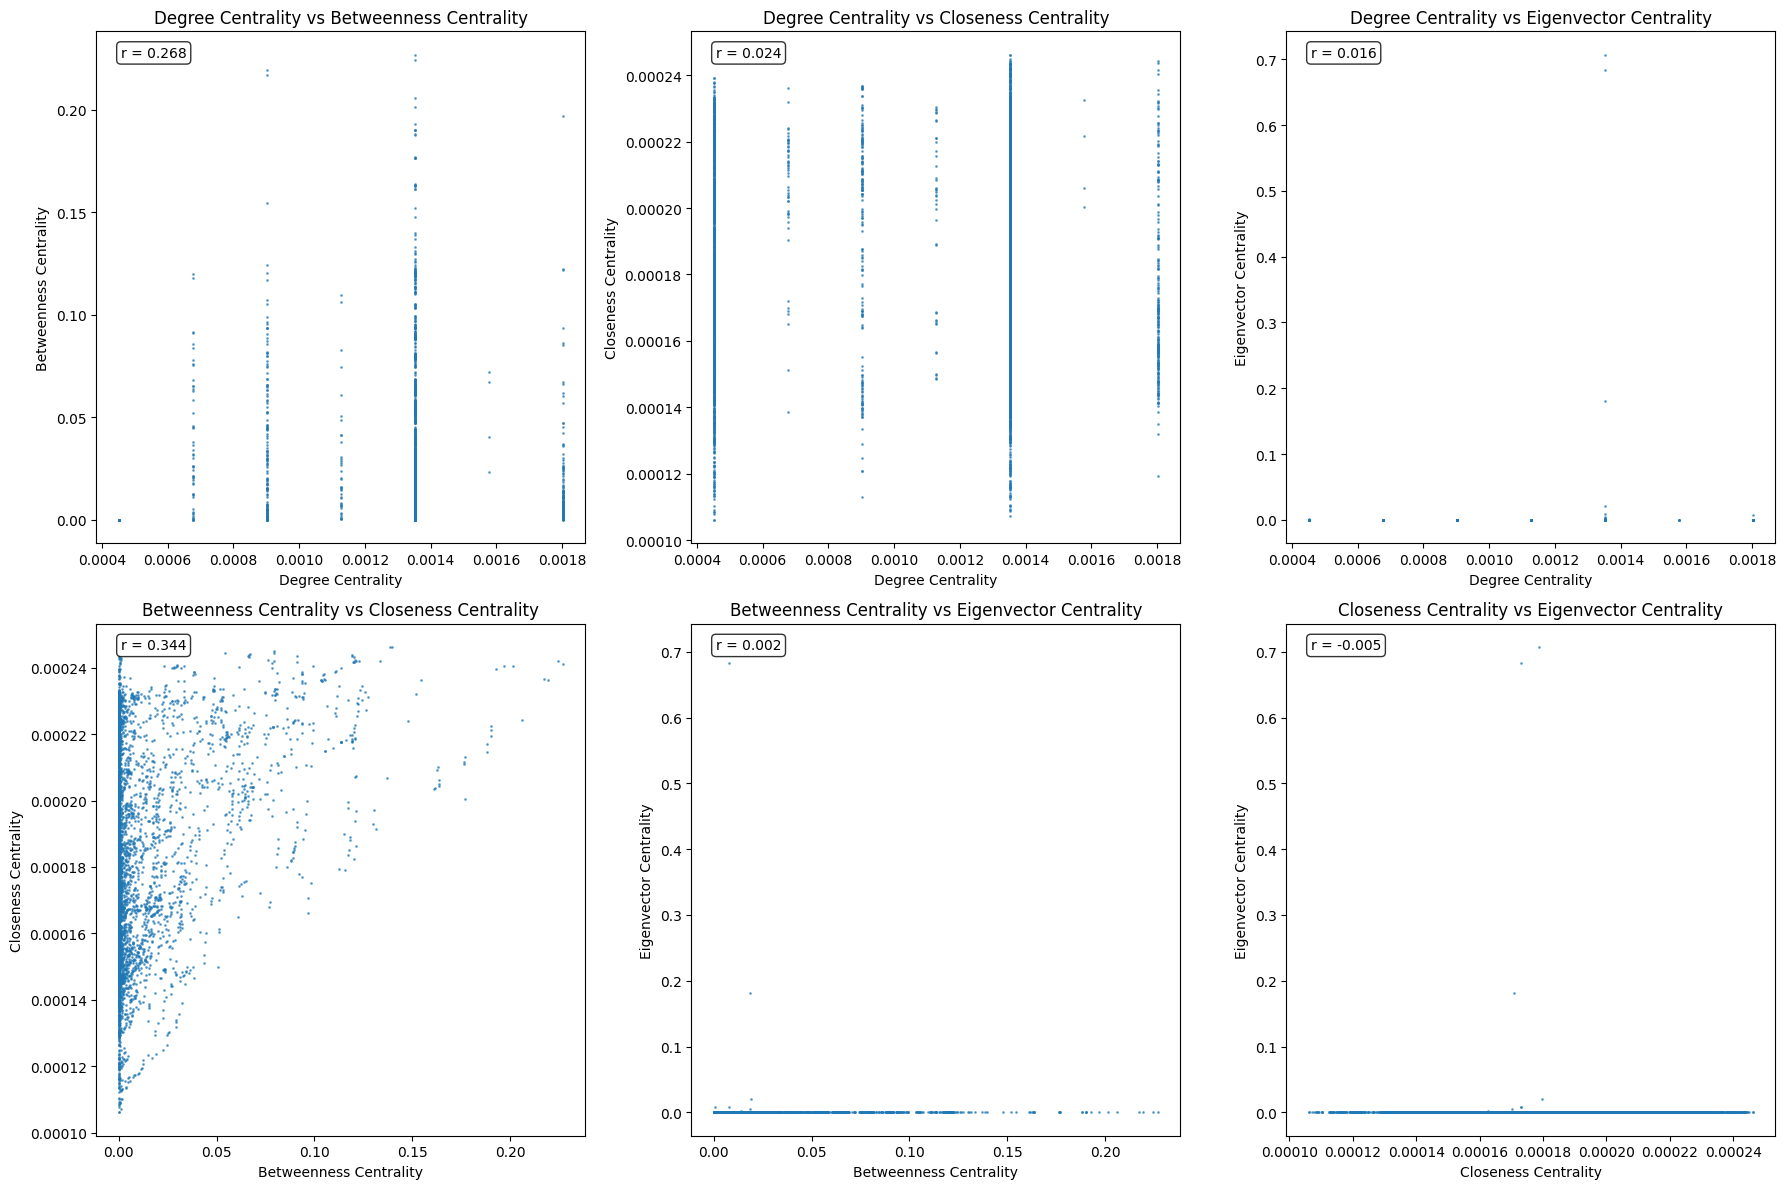

In [12]:
# 3. Scatter plot matrix untuk melihat hubungan antar centrality
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

combinations = [
    ('degree_centrality', 'betweenness_centrality'),
    ('degree_centrality', 'closeness_centrality'),
    ('degree_centrality', 'eigenvector_centrality'),
    ('betweenness_centrality', 'closeness_centrality'),
    ('betweenness_centrality', 'eigenvector_centrality'),
    ('closeness_centrality', 'eigenvector_centrality')
]

for i, (x_metric, y_metric) in enumerate(combinations):
    ax = axes[i]
    ax.scatter(centrality_df[x_metric], centrality_df[y_metric], alpha=0.6, s=1)
    ax.set_xlabel(x_metric.replace('_', ' ').title())
    ax.set_ylabel(y_metric.replace('_', ' ').title())
    ax.set_title(f'{x_metric.replace("_", " ").title()} vs {y_metric.replace("_", " ").title()}')

    # Add correlation coefficient
    corr = centrality_df[x_metric].corr(centrality_df[y_metric])
    ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

##	Visualisasi Jaringan Dengan Centrality

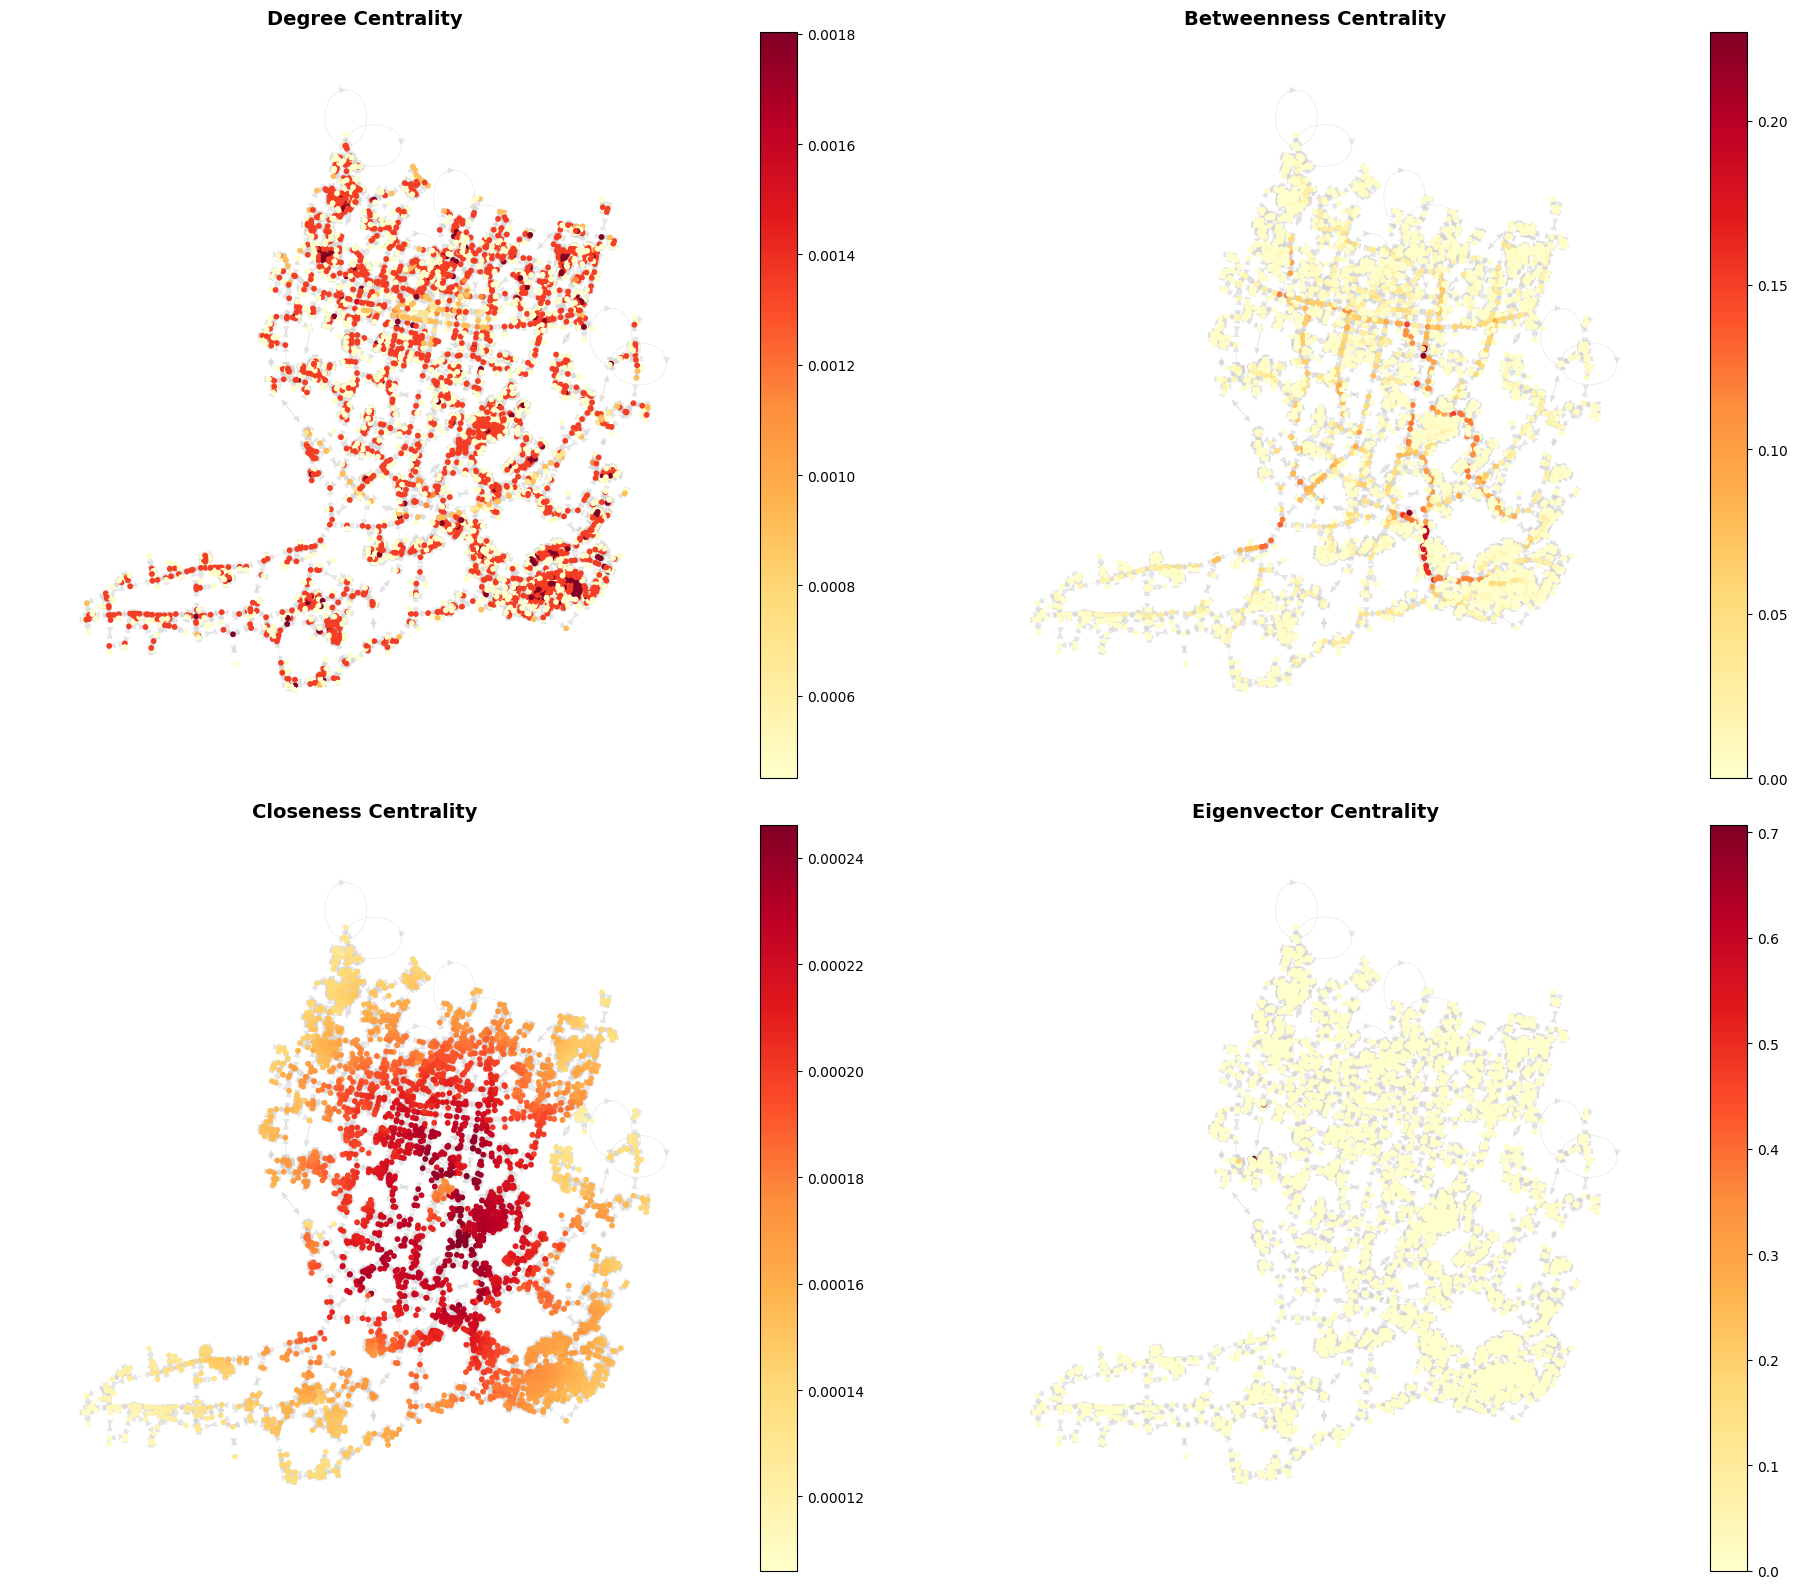

In [13]:
# Visualisasi untuk setiap centrality metric
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
metrics = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality']
titles = ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i//2, i%2]

    # Get centrality values untuk node colors
    node_colors = [centrality_df[centrality_df['node_id'] == node][metric].iloc[0]
                   for node in G.nodes()]

    # Plot graph
    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=0.5, alpha=0.5, ax=ax)

    # Draw nodes with centrality-based colors
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                                   node_size=10, cmap='YlOrRd',
                                   vmin=min(node_colors), vmax=max(node_colors), ax=ax)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    ax.axis('off')

    # Add colorbar
    plt.colorbar(nodes, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

##	Analisis Node Strategis

In [14]:
# Identifikasi node yang masuk top 10% di multiple centrality metrics
centrality_percentiles = centrality_df[['degree_centrality', 'betweenness_centrality',
                                       'closeness_centrality', 'eigenvector_centrality']].quantile(0.9)

strategic_nodes = centrality_df[
    (centrality_df['degree_centrality'] >= centrality_percentiles['degree_centrality']) |
    (centrality_df['betweenness_centrality'] >= centrality_percentiles['betweenness_centrality']) |
    (centrality_df['closeness_centrality'] >= centrality_percentiles['closeness_centrality']) |
    (centrality_df['eigenvector_centrality'] >= centrality_percentiles['eigenvector_centrality'])
].copy()

# Hitung berapa banyak centrality metrics yang tinggi untuk setiap node
strategic_nodes['high_centrality_count'] = (
    (strategic_nodes['degree_centrality'] >= centrality_percentiles['degree_centrality']).astype(int) +
    (strategic_nodes['betweenness_centrality'] >= centrality_percentiles['betweenness_centrality']).astype(int) +
    (strategic_nodes['closeness_centrality'] >= centrality_percentiles['closeness_centrality']).astype(int) +
    (strategic_nodes['eigenvector_centrality'] >= centrality_percentiles['eigenvector_centrality']).astype(int)
)

# Sort berdasarkan jumlah high centrality metrics
strategic_nodes = strategic_nodes.sort_values('high_centrality_count', ascending=False)

print(f"📍 Ditemukan {len(strategic_nodes)} node strategis (top 10% di minimal 1 centrality metric)")
print(f"🏆 {len(strategic_nodes[strategic_nodes['high_centrality_count'] >= 2])} node yang unggul di 2+ centrality metrics")

📍 Ditemukan 3022 node strategis (top 10% di minimal 1 centrality metric)
🏆 847 node yang unggul di 2+ centrality metrics


In [16]:
# Top 20 most strategic nodes
print("\n🏆 TOP 20 MOST STRATEGIC NODES:")
top_strategic = strategic_nodes.head(20)[['node_id', 'high_centrality_count',
                                         'degree_centrality', 'betweenness_centrality',
                                         'closeness_centrality', 'eigenvector_centrality', 'lat', 'lon']]
top_strategic


🏆 TOP 20 MOST STRATEGIC NODES:


node_id  high_centrality_count  degree_centrality  \
17    1989439010                      4           0.001352   
2882  6665869203                      3           0.001352   
450   2918147467                      3           0.001352   
2980  6690275812                      3           0.001352   
3054  6936590693                      3           0.001352   
389   2903662980                      3           0.001352   
375   2903662494                      3           0.001352   
360   2903661587                      3           0.001803   
359   2903661586                      3           0.001352   
358   2903661580                      3           0.001352   
357   2903661579                      3           0.001352   
356   2903661571                      3           0.001352   
3221  7223877712                      3           0.000901   
318   2898849252                      3           0.000901   
314   2898843028                      3           0.000676   
321   2903658934                      3           0.001352   
2946  6669926750                      3           0.001352   
2877  6665813894                      3           0.001352   
2769  6660612522                      3           0.001352   
2771  6660612530                      3           0.001352   

      betweenness_centrality  closeness_centrality  eigenvector_centrality  \
17                  0.076181              0.000242            2.045261e-17   
2882                0.052198              0.000227           -1.413104e-18   
450                 0.060740              0.000165            1.466116e-09   
2980                0.066589              0.000194            2.985989e-11   
3054                0.112399              0.000235           -3.494785e-17   
389                 0.048667              0.000233            6.337628e-18   
375                 0.086041              0.000180            3.596626e-17   
360                 0.121671              0.000226           -2.688358e-18   
359                 0.126237              0.000227           -8.452959e-18   
358                 0.151850              0.000232           -8.209706e-18   
357                 0.125599              0.000233            2.828457e-18   
356                 0.091989              0.000231           -1.838988e-18   
3221                0.117085              0.000230            1.129935e-14   
318                 0.124505              0.000230            9.561425e-17   
314                 0.058266              0.000232            1.078060e-16   
321                 0.052698              0.000230            3.081028e-18   
2946                0.007919              0.000230            2.184797e-17   
2877                0.051418              0.000161            2.095015e-10   
2769                0.080808              0.000232            1.315587e-18   
2771                0.079943              0.000232           -3.576790e-18   

           lat         lon  
17   -6.930262  106.925847  
2882 -6.947371  106.928076  
450  -6.911165  106.913344  
2980 -6.919773  106.913771  
3054 -6.935091  106.934723  
389  -6.939470  106.935158  
375  -6.951352  106.947020  
360  -6.936190  106.939175  
359  -6.935888  106.938890  
358  -6.935952  106.937847  
357  -6.936107  106.937683  
356  -6.935635  106.935469  
3221 -6.946141  106.914946  
318  -6.946203  106.914891  
314  -6.947680  106.916400  
321  -6.935807  106.924599  
2946 -6.926562  106.935331  
2877 -6.909795  106.913511  
2769 -6.945994  106.917661  
2771 -6.945616  106.918089

##	Peta Interaktif Dengan Multi-Centrality

In [17]:
# Create interactive map
m = folium.Map(location=[-6.9281, 106.9317], zoom_start=13, tiles='OpenStreetMap')

# Add different layers for each centrality metric
feature_groups = {}
colors = ['red', 'blue', 'green', 'purple']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    fg = folium.FeatureGroup(name=f'{metric.replace("_", " ").title()}')

    # Get top 50 nodes for this metric
    top_nodes = centrality_df.nlargest(50, metric)

    for _, row in top_nodes.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=5 + row[metric] * 50,  # Size based on centrality value
            popup=f"""
            <b>Node ID:</b> {row['node_id']}<br>
            <b>{metric.replace('_', ' ').title()}:</b> {row[metric]:.4f}<br>
            <b>Rank:</b> {top_nodes.index.get_loc(row.name) + 1}
            """,
            color=color,
            fillColor=color,
            fillOpacity=0.6,
            weight=2
        ).add_to(fg)

    feature_groups[metric] = fg
    m.add_child(fg)

# Add most strategic nodes as special markers
strategic_fg = folium.FeatureGroup(name='Most Strategic Nodes (Top 20)')
for _, row in top_strategic.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"""
        <b>Strategic Node</b><br>
        <b>Node ID:</b> {row['node_id']}<br>
        <b>High Centrality Count:</b> {row['high_centrality_count']}/4<br>
        <b>Degree:</b> {row['degree_centrality']:.4f}<br>
        <b>Betweenness:</b> {row['betweenness_centrality']:.4f}<br>
        <b>Closeness:</b> {row['closeness_centrality']:.4f}<br>
        <b>Eigenvector:</b> {row['eigenvector_centrality']:.4f}
        """,
        icon=folium.Icon(color='black', icon='star')
    ).add_to(strategic_fg)

m.add_child(strategic_fg)

# Add layer control
folium.LayerControl().add_to(m)

# Add legend
legend_html = '''
<div style="position: fixed;
     bottom: 50px; left: 50px; width: 200px; height: 120px;
     background-color: white; border:2px solid grey; z-index:9999;
     font-size:14px; padding: 10px">
<b>Centrality Metrics</b><br>
<i class="fa fa-circle" style="color:red"></i> Degree Centrality<br>
<i class="fa fa-circle" style="color:blue"></i> Betweenness Centrality<br>
<i class="fa fa-circle" style="color:green"></i> Closeness Centrality<br>
<i class="fa fa-circle" style="color:purple"></i> Eigenvector Centrality<br>
<i class="fa fa-star" style="color:black"></i> Strategic Nodes
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

print("✅ Peta interaktif berhasil dibuat!")

✅ Peta interaktif berhasil dibuat!


In [18]:
# Display the map
m

##	Summary dan Insights

In [20]:
print("\n📝 SUMMARY DAN INSIGHTS:")
print("="*80)
print(f"🏙️  KOTA ANALISIS: Kota Sukabumi, Jawa Barat")
#print(f"📊  TOTAL NODES: {len(nodes):,}")
#print(f"🛣️   TOTAL EDGES: {len(edges):,}")
print(f"📊  TOTAL NODES: {len(G.nodes()):,}")
print(f"🛣️   TOTAL EDGES: {len(G.edges()):,}")
print(f"🎯  STRATEGIC NODES: {len(strategic_nodes):,}")
print(f"🏆  MULTI-METRIC LEADERS: {len(strategic_nodes[strategic_nodes['high_centrality_count'] >= 3]):,}")

print(f"\n📈 CENTRALITY STATISTICS:")
for metric in metrics:
    mean_val = centrality_df[metric].mean()
    std_val = centrality_df[metric].std()
    max_val = centrality_df[metric].max()
    print(f"   {metric.replace('_', ' ').title():.<25} Mean: {mean_val:.6f}, Std: {std_val:.6f}, Max: {max_val:.6f}")

print(f"\n🔗 CENTRALITY CORRELATIONS:")
for i, metric1 in enumerate(metrics):
    for metric2 in metrics[i+1:]:
        corr = centrality_df[metric1].corr(centrality_df[metric2])
        print(f"   {metric1.replace('_', ' ').title()} vs {metric2.replace('_', ' ').title()}: {corr:.3f}")

print(f"\n💡 KEY INSIGHTS:")
print(f"   • Node dengan degree centrality tertinggi menunjukkan persimpangan tersibuk")
print(f"   • Node dengan betweenness centrality tinggi adalah 'bottleneck' dalam jaringan")
print(f"   • Node dengan closeness centrality tinggi memiliki akses tercepat ke seluruh jaringan")
print(f"   • Node dengan eigenvector centrality tinggi terhubung dengan node-node penting lainnya")
print(f"   • {len(strategic_nodes[strategic_nodes['high_centrality_count'] >= 2])} node strategis perlu perhatian khusus untuk pengembangan infrastruktur")

print("\n🎯 REKOMENDASI:")
print("   1. Prioritaskan pengembangan infrastruktur di node dengan multiple high centrality")
print("   2. Monitor bottleneck nodes (high betweenness) untuk mencegah kemacetan")
print("   3. Manfaatkan strategic nodes untuk penempatan fasilitas publik")
print("   4. Pertimbangkan redundansi jalur di area dengan centrality tinggi")

print("\n✅ Multi-Centrality Analysis selesai!")
print("="*80)


📝 SUMMARY DAN INSIGHTS:
🏙️  KOTA ANALISIS: Kota Sukabumi, Jawa Barat
📊  TOTAL NODES: 4,439
🛣️   TOTAL EDGES: 10,329
🎯  STRATEGIC NODES: 3,022
🏆  MULTI-METRIC LEADERS: 163

📈 CENTRALITY STATISTICS:
   Degree Centrality........ Mean: 0.001049, Std: 0.000450, Max: 0.001803
   Betweenness Centrality... Mean: 0.013017, Std: 0.027342, Max: 0.226847
   Closeness Centrality..... Mean: 0.000182, Std: 0.000031, Max: 0.000246
   Eigenvector Centrality... Mean: 0.000366, Std: 0.015006, Max: 0.706985

🔗 CENTRALITY CORRELATIONS:
   Degree Centrality vs Betweenness Centrality: 0.268
   Degree Centrality vs Closeness Centrality: 0.024
   Degree Centrality vs Eigenvector Centrality: 0.016
   Betweenness Centrality vs Closeness Centrality: 0.344
   Betweenness Centrality vs Eigenvector Centrality: 0.002
   Closeness Centrality vs Eigenvector Centrality: -0.005

💡 KEY INSIGHTS:
   • Node dengan degree centrality tertinggi menunjukkan persimpangan tersibuk
   • Node dengan betweenness centrality tinggi a

# HEALTHCARE ACCESSIBILITY ANALYSIS

In [21]:
# Ambil data fasilitas kesehatan dari OSM
try:
    # Rumah Sakit
    hospitals = ox.features_from_place(place, tags={'amenity': 'hospital'})
    print(f"🏥 Rumah Sakit ditemukan: {len(hospitals)}")
except Exception as e:
    print(f"⚠️  Tidak ada data rumah sakit: {e}")
    hospitals = gpd.GeoDataFrame()

try:
    # Klinik
    clinics = ox.features_from_place(place, tags={'amenity': 'clinic'})
    print(f"🏥 Klinik ditemukan: {len(clinics)}")
except Exception as e:
    print(f"⚠️  Tidak ada data klinik: {e}")
    clinics = gpd.GeoDataFrame()

try:
    # Apotek
    pharmacies = ox.features_from_place(place, tags={'amenity': 'pharmacy'})
    print(f"💊 Apotek ditemukan: {len(pharmacies)}")
except Exception as e:
    print(f"⚠️  Tidak ada data apotek: {e}")
    pharmacies = gpd.GeoDataFrame()

try:
    # Dokter
    doctors = ox.features_from_place(place, tags={'amenity': 'doctors'})
    print(f"👨‍⚕️ Praktik Dokter ditemukan: {len(doctors)}")
except Exception as e:
    print(f"⚠️  Tidak ada data praktik dokter: {e}")
    doctors = gpd.GeoDataFrame()

try:
    # Puskesmas (menggunakan tag yang lebih umum)
    health_centers = ox.features_from_place(place, tags={'healthcare': 'centre'})
    print(f"🏥 Pusat Kesehatan ditemukan: {len(health_centers)}")
except Exception as e:
    print(f"⚠️  Tidak ada data pusat kesehatan: {e}")
    health_centers = gpd.GeoDataFrame()

🏥 Rumah Sakit ditemukan: 14
🏥 Klinik ditemukan: 18
💊 Apotek ditemukan: 16
👨‍⚕️ Praktik Dokter ditemukan: 13
⚠️  Tidak ada data pusat kesehatan: No matching features. Check query location, tags, and log.


In [22]:
# Fungsi untuk mengekstrak koordinat dari geometry
def extract_coordinates(gdf, facility_type):
    """Extract coordinates from GeoDataFrame"""
    coords_list = []

    if len(gdf) == 0:
        return pd.DataFrame(columns=['facility_type', 'name', 'lat', 'lon'])

    for idx, row in gdf.iterrows():
        try:
            if row.geometry.geom_type == 'Point':
                lat, lon = row.geometry.y, row.geometry.x
            elif row.geometry.geom_type in ['Polygon', 'MultiPolygon']:
                centroid = row.geometry.centroid
                lat, lon = centroid.y, centroid.x
            else:
                continue

            # Get name
            name = row.get('name', f'{facility_type}_{len(coords_list)+1}')
            if pd.isna(name):
                name = f'{facility_type}_{len(coords_list)+1}'

            coords_list.append({
                'facility_type': facility_type,
                'name': name,
                'lat': lat,
                'lon': lon,
                'osmid': idx
            })
        except Exception as e:
            continue

    return pd.DataFrame(coords_list)

# Extract coordinates untuk semua fasilitas kesehatan
print("\n🔄 Preprocessing data fasilitas kesehatan...")


🔄 Preprocessing data fasilitas kesehatan...


In [23]:
healthcare_facilities = pd.concat([
    extract_coordinates(hospitals, 'Hospital'),
    extract_coordinates(clinics, 'Clinic'),
    extract_coordinates(pharmacies, 'Pharmacy'),
    extract_coordinates(doctors, 'Doctor'),
    extract_coordinates(health_centers, 'Health_Center')
], ignore_index=True)

print(f"✅ Total fasilitas kesehatan berhasil diproses: {len(healthcare_facilities)}")

✅ Total fasilitas kesehatan berhasil diproses: 61


In [24]:
if len(healthcare_facilities) > 0:
    print("\n📊 Distribusi Fasilitas Kesehatan:")
    facility_counts = healthcare_facilities['facility_type'].value_counts()
    for facility, count in facility_counts.items():
        print(f"   {facility}: {count}")

    # Display first few facilities
    print(f"\n📋 Sample Fasilitas Kesehatan:")
    print(healthcare_facilities.head())


📊 Distribusi Fasilitas Kesehatan:
   Clinic: 18
   Pharmacy: 16
   Hospital: 14
   Doctor: 13

📋 Sample Fasilitas Kesehatan:
  facility_type        name       lat         lon               osmid
0      Hospital  Hospital_1 -6.922142  106.923506  (node, 7880505294)
1      Hospital  Hospital_2 -6.919087  106.916932  (node, 7880510889)
2      Hospital  Hospital_3 -6.915330  106.935116  (node, 7902306431)
3      Hospital  Hospital_4 -6.916320  106.935015  (node, 7902306432)
4      Hospital  Hospital_5 -6.916619  106.935249  (node, 7902307685)


## Analisis Aksesibilitas Kesehatan

In [25]:
def calculate_nearest_healthcare_distance(node_lat, node_lon, healthcare_df):
    """Calculate distance to nearest healthcare facility"""
    if len(healthcare_df) == 0:
        return np.inf, 'None', 'None'

    # Calculate distances using haversine formula
    from math import radians, cos, sin, asin, sqrt

    def haversine(lon1, lat1, lon2, lat2):
        # Convert decimal degrees to radians
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a))
        r = 6371  # Radius of earth in kilometers
        return c * r

    distances = []
    for _, facility in healthcare_df.iterrows():
        dist = haversine(node_lon, node_lat, facility['lon'], facility['lat'])
        distances.append((dist, facility['facility_type'], facility['name']))

    # Find nearest facility
    nearest = min(distances, key=lambda x: x[0])
    return nearest[0], nearest[1], nearest[2]

print("\n📏 Menghitung aksesibilitas kesehatan untuk setiap node...")


📏 Menghitung aksesibilitas kesehatan untuk setiap node...


In [26]:
# Calculate healthcare accessibility for each node
if len(healthcare_facilities) > 0:
    healthcare_accessibility = []

    # Process in batches untuk efisiensi
    node_list = list(G.nodes(data=True))
    batch_size = 100
    total_batches = len(node_list) // batch_size + 1

    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(node_list))
        batch_nodes = node_list[start_idx:end_idx]

        for node_id, node_data in batch_nodes:
            nearest_dist, nearest_type, nearest_name = calculate_nearest_healthcare_distance(
                node_data['y'], node_data['x'], healthcare_facilities
            )

            healthcare_accessibility.append({
                'node_id': node_id,
                'lat': node_data['y'],
                'lon': node_data['x'],
                'nearest_healthcare_distance': nearest_dist,
                'nearest_healthcare_type': nearest_type,
                'nearest_healthcare_name': nearest_name
            })

        if batch_idx % 10 == 0:
            progress = (batch_idx + 1) / total_batches * 100
            print(f"   Progress: {progress:.1f}% ({batch_idx + 1}/{total_batches} batches)")

    # Convert to DataFrame
    healthcare_access_df = pd.DataFrame(healthcare_accessibility)

    # Merge dengan centrality data
    integrated_analysis = centrality_df.merge(healthcare_access_df, on=['node_id', 'lat', 'lon'], how='left')

    print(f"✅ Analisis aksesibilitas kesehatan selesai!")

    # 📊 STATISTIK AKSESIBILITAS KESEHATAN
    print(f"\n📊 STATISTIK AKSESIBILITAS KESEHATAN:")
    print(f"   Mean jarak ke fasilitas kesehatan: {healthcare_access_df['nearest_healthcare_distance'].mean():.2f} km")
    print(f"   Median jarak: {healthcare_access_df['nearest_healthcare_distance'].median():.2f} km")
    print(f"   Jarak maksimum: {healthcare_access_df['nearest_healthcare_distance'].max():.2f} km")
    print(f"   Jarak minimum: {healthcare_access_df['nearest_healthcare_distance'].min():.2f} km")

else:
    print("⚠️  Tidak ada data fasilitas kesehatan yang ditemukan. Melanjutkan dengan analisis terbatas...")
    integrated_analysis = centrality_df.copy()
    integrated_analysis['nearest_healthcare_distance'] = np.inf
    integrated_analysis['nearest_healthcare_type'] = 'None'
    integrated_analysis['nearest_healthcare_name'] = 'None'

   Progress: 2.2% (1/45 batches)
   Progress: 24.4% (11/45 batches)
   Progress: 46.7% (21/45 batches)
   Progress: 68.9% (31/45 batches)
   Progress: 91.1% (41/45 batches)
✅ Analisis aksesibilitas kesehatan selesai!

📊 STATISTIK AKSESIBILITAS KESEHATAN:
   Mean jarak ke fasilitas kesehatan: 1.64 km
   Median jarak: 1.33 km
   Jarak maksimum: 5.89 km
   Jarak minimum: 0.01 km


## Identifikasi Healthcare Deserts

In [27]:
if len(healthcare_facilities) > 0:
    print("\n🏥 IDENTIFIKASI HEALTHCARE DESERTS...")

    # Define healthcare desert threshold (misalnya > 5km dari fasilitas kesehatan)
    healthcare_desert_threshold = 5.0  # km

    healthcare_deserts = integrated_analysis[
        integrated_analysis['nearest_healthcare_distance'] > healthcare_desert_threshold
    ].copy()

    print(f"🚨 Healthcare Desert Areas: {len(healthcare_deserts)} nodes (>{healthcare_desert_threshold}km dari fasilitas kesehatan)")

    if len(healthcare_deserts) > 0:
        print(f"   Persentase area dengan akses kesehatan rendah: {len(healthcare_deserts)/len(integrated_analysis)*100:.1f}%")

        # Healthcare deserts yang juga strategic nodes
        strategic_healthcare_deserts = healthcare_deserts[
            healthcare_deserts['node_id'].isin(strategic_nodes['node_id'])
        ]

        print(f"   Strategic nodes dalam healthcare deserts: {len(strategic_healthcare_deserts)}")


🏥 IDENTIFIKASI HEALTHCARE DESERTS...
🚨 Healthcare Desert Areas: 53 nodes (>5.0km dari fasilitas kesehatan)
   Persentase area dengan akses kesehatan rendah: 1.2%
   Strategic nodes dalam healthcare deserts: 31


## Analisis Integrasi: Strategic Nodes vs Healthcare Access

In [28]:
if len(healthcare_facilities) > 0:
    # Merge strategic nodes dengan healthcare access
    strategic_healthcare_analysis = strategic_nodes.merge(
        healthcare_access_df[['node_id', 'nearest_healthcare_distance', 'nearest_healthcare_type', 'nearest_healthcare_name']],
        on='node_id', how='left'
    )

    # Analisis strategic nodes dengan akses kesehatan yang baik/buruk
    good_healthcare_access = strategic_healthcare_analysis[
        strategic_healthcare_analysis['nearest_healthcare_distance'] <= 2.0  # <= 2km
    ]

    poor_healthcare_access = strategic_healthcare_analysis[
        strategic_healthcare_analysis['nearest_healthcare_distance'] > 3.0   # > 3km
    ]

    print(f"✅ Strategic nodes dengan akses kesehatan baik (≤2km): {len(good_healthcare_access)}")
    print(f"❌ Strategic nodes dengan akses kesehatan buruk (>3km): {len(poor_healthcare_access)}")

    if len(poor_healthcare_access) > 0:
        print(f"\n🚨 STRATEGIC NODES DENGAN AKSES KESEHATAN BURUK:")
        priority_nodes = poor_healthcare_access.nlargest(10, 'high_centrality_count')[
            ['node_id', 'high_centrality_count', 'nearest_healthcare_distance', 'nearest_healthcare_type', 'lat', 'lon']
        ]
        print(priority_nodes)

✅ Strategic nodes dengan akses kesehatan baik (≤2km): 2105
❌ Strategic nodes dengan akses kesehatan buruk (>3km): 599

🚨 STRATEGIC NODES DENGAN AKSES KESEHATAN BURUK:
         node_id  high_centrality_count  nearest_healthcare_distance  \
133  11734855893                      3                     3.303364   
181   5847752010                      2                     4.560550   
184   5847752044                      2                     5.345285   
217   6024381334                      2                     3.104672   
218   6026221634                      2                     3.750201   
219   6026231733                      2                     3.752310   
220   6026257368                      2                     4.016519   
224   5847752641                      2                     3.127178   
225   5847752664                      2                     3.340573   
226   5847752080                      2                     5.273474   

    nearest_healthcare_type       lat   

## Visualisasi Healthcare Accessibility


📊 Membuat visualisasi healthcare accessibility...


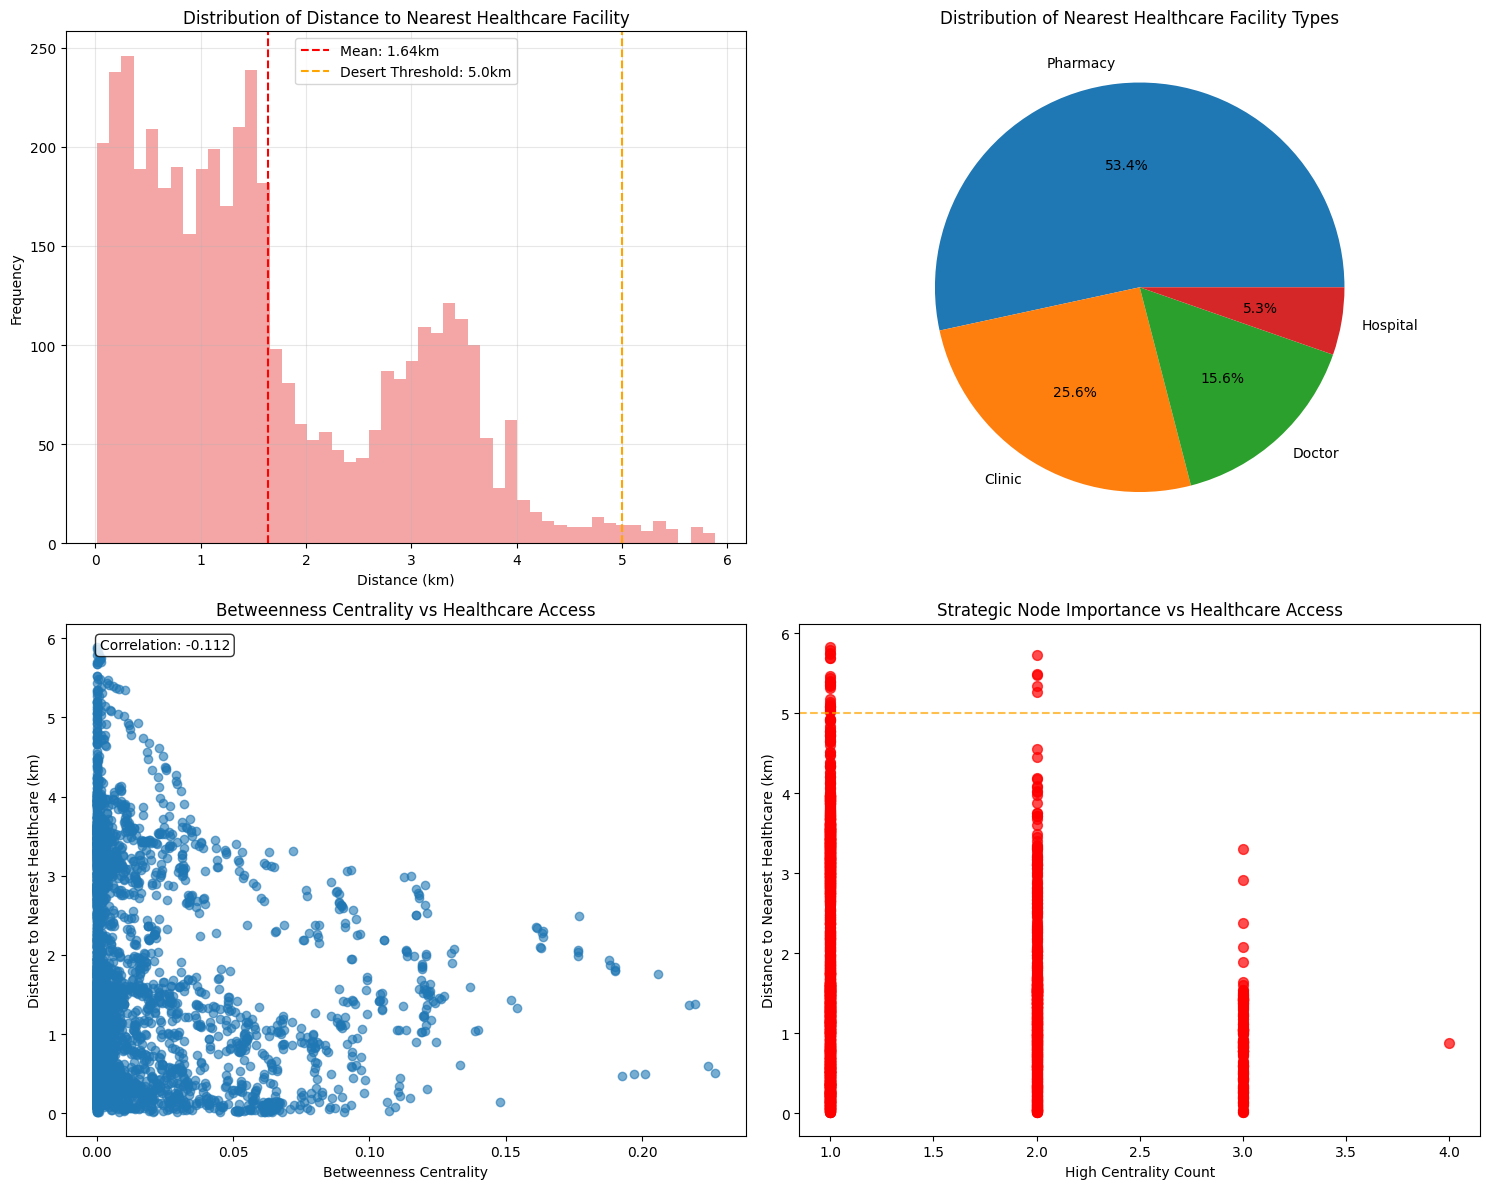

In [29]:
if len(healthcare_facilities) > 0:
    print("\n📊 Membuat visualisasi healthcare accessibility...")

    # 1. Healthcare Access Distribution
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Distance distribution
    axes[0,0].hist(healthcare_access_df['nearest_healthcare_distance'], bins=50, alpha=0.7, color='lightcoral')
    axes[0,0].axvline(healthcare_access_df['nearest_healthcare_distance'].mean(), color='red', linestyle='--',
                      label=f'Mean: {healthcare_access_df["nearest_healthcare_distance"].mean():.2f}km')
    axes[0,0].axvline(healthcare_desert_threshold, color='orange', linestyle='--',
                      label=f'Desert Threshold: {healthcare_desert_threshold}km')
    axes[0,0].set_title('Distribution of Distance to Nearest Healthcare Facility')
    axes[0,0].set_xlabel('Distance (km)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Facility type distribution
    facility_access_counts = healthcare_access_df['nearest_healthcare_type'].value_counts()
    axes[0,1].pie(facility_access_counts.values, labels=facility_access_counts.index, autopct='%1.1f%%')
    axes[0,1].set_title('Distribution of Nearest Healthcare Facility Types')

    # Correlation: Centrality vs Healthcare Access
    axes[1,0].scatter(integrated_analysis['betweenness_centrality'],
                      integrated_analysis['nearest_healthcare_distance'], alpha=0.6)
    axes[1,0].set_xlabel('Betweenness Centrality')
    axes[1,0].set_ylabel('Distance to Nearest Healthcare (km)')
    axes[1,0].set_title('Betweenness Centrality vs Healthcare Access')
    correlation = integrated_analysis['betweenness_centrality'].corr(integrated_analysis['nearest_healthcare_distance'])
    axes[1,0].text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=axes[1,0].transAxes,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Strategic nodes healthcare access
    if len(strategic_healthcare_analysis) > 0:
        axes[1,1].scatter(strategic_healthcare_analysis['high_centrality_count'],
                          strategic_healthcare_analysis['nearest_healthcare_distance'],
                          alpha=0.7, s=50, c='red')
        axes[1,1].set_xlabel('High Centrality Count')
        axes[1,1].set_ylabel('Distance to Nearest Healthcare (km)')
        axes[1,1].set_title('Strategic Node Importance vs Healthcare Access')
        axes[1,1].axhline(healthcare_desert_threshold, color='orange', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

## Peta Interaktif Healthcare Accessibility

In [33]:
# Create new interactive map for healthcare analysis
healthcare_map = folium.Map(location=[-6.9281, 106.9317], zoom_start=13, tiles='OpenStreetMap')

# Add healthcare facilities
if len(healthcare_facilities) > 0:
    facility_colors = {
        'Hospital': 'red',
        'Clinic': 'blue',
        'Pharmacy': 'green',
        'Doctor': 'purple',
        'Health_Center': 'orange'
    }

    healthcare_fg = folium.FeatureGroup(name='Healthcare Facilities')

    for _, facility in healthcare_facilities.iterrows():
        color = facility_colors.get(facility['facility_type'], 'gray')
        folium.Marker(
            location=[facility['lat'], facility['lon']],
            popup=f"""
            <b>{facility['facility_type']}</b><br>
            <b>Name:</b> {facility['name']}<br>
            <b>Coordinates:</b> {facility['lat']:.4f}, {facility['lon']:.4f}
            """,
            icon=folium.Icon(color=color, icon='plus-sign')
        ).add_to(healthcare_fg)

    healthcare_map.add_child(healthcare_fg)

# Add healthcare accessibility heatmap
if len(healthcare_facilities) > 0 and len(healthcare_access_df) > 0:
    # Create healthcare access categories
    def get_access_category(distance):
        if distance <= 1.0:
            return 'Excellent', 'green'
        elif distance <= 2.0:
            return 'Good', 'lightgreen'
        elif distance <= 3.0:
            return 'Fair', 'yellow'
        elif distance <= 5.0:
            return 'Poor', 'orange'
        else:
            return 'Very Poor', 'red'

    access_fg = folium.FeatureGroup(name='Healthcare Accessibility')

    # Sample nodes untuk visualisasi (setiap 10 node untuk performance)
    sample_access = healthcare_access_df.iloc[::10]

    for _, row in sample_access.iterrows():
        category, color = get_access_category(row['nearest_healthcare_distance'])

        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=3,
            popup=f"""
            <b>Healthcare Access: {category}</b><br>
            <b>Distance:</b> {row['nearest_healthcare_distance']:.2f} km<br>
            <b>Nearest:</b> {row['nearest_healthcare_type']}<br>
            <b>Facility:</b> {row['nearest_healthcare_name']}
            """,
            color=color,
            fillColor=color,
            fillOpacity=0.7,
            weight=1
        ).add_to(access_fg)

    healthcare_map.add_child(access_fg)

# Add strategic nodes dengan healthcare access analysis
if len(healthcare_facilities) > 0 and 'strategic_healthcare_analysis' in locals():
    strategic_healthcare_fg = folium.FeatureGroup(name='Strategic Nodes + Healthcare Access')

    for _, row in strategic_healthcare_analysis.head(20).iterrows():  # Top 20 strategic nodes
        # Determine marker color based on healthcare access
        if row['nearest_healthcare_distance'] <= 2.0:
            marker_color = 'green'
            access_status = 'Good Access'
        elif row['nearest_healthcare_distance'] <= 5.0:
            marker_color = 'orange'
            access_status = 'Limited Access'
        else:
            marker_color = 'red'
            access_status = 'Poor Access'

        folium.Marker(
            location=[row['lat'], row['lon']],
            popup=f"""
            <b>Strategic Node - {access_status}</b><br>
            <b>Node ID:</b> {row['node_id']}<br>
            <b>Centrality Count:</b> {row['high_centrality_count']}/4<br>
            <b>Healthcare Distance:</b> {row['nearest_healthcare_distance']:.2f} km<br>
            <b>Nearest Facility:</b> {row['nearest_healthcare_type']}<br>
            <b>Facility Name:</b> {row['nearest_healthcare_name']}
            """,
            icon=folium.Icon(color=marker_color, icon='star')
        ).add_to(strategic_healthcare_fg)

    healthcare_map.add_child(strategic_healthcare_fg)

# Add layer control
folium.LayerControl().add_to(healthcare_map)

# Add legend for healthcare map
healthcare_legend_html = '''
<div style="position: fixed;
     bottom: 50px; left: 50px; width: 250px; height: 200px;
     background-color: white; border:2px solid grey; z-index:9999;
     font-size:12px; padding: 10px">
<b>Healthcare Accessibility Legend</b><br><br>
<b>Healthcare Facilities:</b><br>
<i class="fa fa-plus" style="color:red"></i> Hospital<br>
<i class="fa fa-plus" style="color:blue"></i> Clinic<br>
<i class="fa fa-plus" style="color:green"></i> Pharmacy<br>
<i class="fa fa-plus" style="color:purple"></i> Doctor<br>
<i class="fa fa-plus" style="color:orange"></i> Health Center<br><br>
<b>Access Quality:</b><br>
<i class="fa fa-circle" style="color:green"></i> Excellent (≤1km)<br>
<i class="fa fa-circle" style="color:lightgreen"></i> Good (≤2km)<br>
<i class="fa fa-circle" style="color:yellow"></i> Fair (≤3km)<br>
<i class="fa fa-circle" style="color:orange"></i> Poor (≤5km)<br>
<i class="fa fa-circle" style="color:red"></i> Very Poor (>5km)
</div>
'''
healthcare_map.get_root().html.add_child(folium.Element(healthcare_legend_html))

print("✅ Peta healthcare accessibility berhasil dibuat!")

✅ Peta healthcare accessibility berhasil dibuat!


In [34]:
healthcare_map

## Rekomendasi Penempatan Fasilitas Kesehatan

In [32]:
print("\n💡 REKOMENDASI PENEMPATAN FASILITAS KESEHATAN")
print("="*60)

if len(healthcare_facilities) > 0:
    # 1. Prioritas berdasarkan strategic nodes dengan akses kesehatan buruk
    if len(poor_healthcare_access) > 0:
        print("🏆 TOP PRIORITY LOCATIONS untuk fasilitas kesehatan baru:")
        top_priority = poor_healthcare_access.nlargest(5, 'high_centrality_count')[
            ['node_id', 'high_centrality_count', 'nearest_healthcare_distance', 'lat', 'lon']
        ]

        for idx, row in top_priority.iterrows():
            print(f"   Priority {idx+1}: Node {row['node_id']} - Centrality Score: {row['high_centrality_count']}/4")
            print(f"                Distance to healthcare: {row['nearest_healthcare_distance']:.2f}km")
            print(f"                Coordinates: ({row['lat']:.4f}, {row['lon']:.4f})")
            print()

    # 2. Analisis coverage gaps
    if 'healthcare_deserts' in locals() and len(healthcare_deserts) > 0:
        print(f"🚨 COVERAGE GAPS ANALYSIS:")
        print(f"   Total healthcare desert areas: {len(healthcare_deserts)} nodes")
        print(f"   Average distance in desert areas: {healthcare_deserts['nearest_healthcare_distance'].mean():.2f}km")

        # Cluster analysis untuk optimal placement
        from sklearn.cluster import KMeans

        if len(healthcare_deserts) >= 3:  # Minimum untuk clustering
            desert_coords = healthcare_deserts[['lat', 'lon']].values
            n_clusters = min(5, len(healthcare_deserts) // 20)  # Max 5 clusters

            if n_clusters >= 2:
                kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
                clusters = kmeans.fit_predict(desert_coords)

                print(f"\n📍 OPTIMAL PLACEMENT RECOMMENDATIONS ({n_clusters} locations):")
                for i in range(n_clusters):
                    centroid = kmeans.cluster_centers_[i]
                    cluster_size = sum(clusters == i)
                    print(f"   Location {i+1}: ({centroid[0]:.4f}, {centroid[1]:.4f})")
                    print(f"                Would serve {cluster_size} underserved nodes")

else:
    print("⚠️  Tidak ada data fasilitas kesehatan yang memadai untuk analisis rekomendasi")


💡 REKOMENDASI PENEMPATAN FASILITAS KESEHATAN
🏆 TOP PRIORITY LOCATIONS untuk fasilitas kesehatan baru:
   Priority 134: Node 11734855893.0 - Centrality Score: 3.0/4
                Distance to healthcare: 3.30km
                Coordinates: (-6.9546, 106.9494)

   Priority 182: Node 5847752010.0 - Centrality Score: 2.0/4
                Distance to healthcare: 4.56km
                Coordinates: (-6.9610, 106.8853)

   Priority 185: Node 5847752044.0 - Centrality Score: 2.0/4
                Distance to healthcare: 5.35km
                Coordinates: (-6.9629, 106.8783)

   Priority 218: Node 6024381334.0 - Centrality Score: 2.0/4
                Distance to healthcare: 3.10km
                Coordinates: (-6.9654, 106.9063)

   Priority 219: Node 6026221634.0 - Centrality Score: 2.0/4
                Distance to healthcare: 3.75km
                Coordinates: (-6.9681, 106.9001)

🚨 COVERAGE GAPS ANALYSIS:
   Total healthcare desert areas: 53 nodes
   Average distance in desert areas: 

## Kesimpulan

In [36]:
print("\n" + "="*80)
print("📝 COMPREHENSIVE ANALYSIS SUMMARY")
print("="*80)

print(f"🏙️  ANALISIS WILAYAH: Kota Sukabumi, Jawa Barat")
print(f"📊  TOTAL NETWORK NODES: {len(G.nodes()):,}")
print(f"🛣️   TOTAL NETWORK EDGES: {len(G.edges()):,}")

if len(healthcare_facilities) > 0:
    print(f"🏥  TOTAL HEALTHCARE FACILITIES: {len(healthcare_facilities)}")
    for facility_type, count in healthcare_facilities['facility_type'].value_counts().items():
        print(f"     • {facility_type}: {count}")

    print(f"\n📏 HEALTHCARE ACCESSIBILITY METRICS:")
    print(f"     • Mean distance to healthcare: {healthcare_access_df['nearest_healthcare_distance'].mean():.2f} km")
    print(f"     • Median distance: {healthcare_access_df['nearest_healthcare_distance'].median():.2f} km")
    print(f"     • Healthcare desert areas (>{healthcare_desert_threshold}km): {len(healthcare_deserts) if 'healthcare_deserts' in locals() else 0}")

    if 'strategic_healthcare_analysis' in locals():
        print(f"\n🎯 STRATEGIC NODES & HEALTHCARE INTEGRATION:")
        print(f"     • Strategic nodes with good healthcare access (≤2km): {len(good_healthcare_access) if 'good_healthcare_access' in locals() else 0}")
        print(f"     • Strategic nodes with poor healthcare access (>3km): {len(poor_healthcare_access) if 'poor_healthcare_access' in locals() else 0}")

        if 'poor_healthcare_access' in locals() and len(poor_healthcare_access) > 0:
            print(f"     • Priority strategic nodes for healthcare development: {len(poor_healthcare_access)}")

print(f"\n💡 KEY FINDINGS:")
print(f"   • Network analysis mengidentifikasi {len(strategic_nodes)} strategic transportation nodes")
print(f"   • Multi-centrality analysis menunjukkan korelasi antar centrality metrics")

if len(healthcare_facilities) > 0:
    print(f"   • Healthcare accessibility analysis mengungkap gap dalam pelayanan kesehatan")
    if 'healthcare_deserts' in locals():
        print(f"   • {len(healthcare_deserts)} area teridentifikasi sebagai healthcare deserts")
    print(f"   • Integrasi analysis menunjukkan strategic nodes yang perlu prioritas healthcare development")

print(f"\n🚀 ACTIONABLE RECOMMENDATIONS:")
print(f"   1. Prioritaskan pengembangan infrastruktur di strategic nodes")
print(f"   2. Monitor dan kelola bottleneck points dalam jaringan transportasi")

if len(healthcare_facilities) > 0:
    print(f"   3. Bangun fasilitas kesehatan di area dengan akses kesehatan rendah")
    print(f"   4. Integrasikan strategic transportation nodes dengan healthcare facility planning")
    if 'poor_healthcare_access' in locals() and len(poor_healthcare_access) > 0:
        print(f"   5. Focus immediate healthcare development pada {len(poor_healthcare_access)} strategic nodes dengan akses kesehatan buruk")

print(f"\n✅ INTEGRATED GEOSPATIAL BIG DATA ANALYSIS COMPLETED!")
print("="*80)

# Display the healthcare map
healthcare_map


📝 COMPREHENSIVE ANALYSIS SUMMARY
🏙️  ANALISIS WILAYAH: Kota Sukabumi, Jawa Barat
📊  TOTAL NETWORK NODES: 4,439
🛣️   TOTAL NETWORK EDGES: 10,329
🏥  TOTAL HEALTHCARE FACILITIES: 61
     • Clinic: 18
     • Pharmacy: 16
     • Hospital: 14
     • Doctor: 13

📏 HEALTHCARE ACCESSIBILITY METRICS:
     • Mean distance to healthcare: 1.64 km
     • Median distance: 1.33 km
     • Healthcare desert areas (>5.0km): 53

🎯 STRATEGIC NODES & HEALTHCARE INTEGRATION:
     • Strategic nodes with good healthcare access (≤2km): 2105
     • Strategic nodes with poor healthcare access (>3km): 599
     • Priority strategic nodes for healthcare development: 599

💡 KEY FINDINGS:
   • Network analysis mengidentifikasi 3022 strategic transportation nodes
   • Multi-centrality analysis menunjukkan korelasi antar centrality metrics
   • Healthcare accessibility analysis mengungkap gap dalam pelayanan kesehatan
   • 53 area teridentifikasi sebagai healthcare deserts
   • Integrasi analysis menunjukkan strategic 